Urban Data Science & Smart Cities <br>
URSP688Y <br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

[<img src="https://colab.research.google.com/assets/colab-badge.svg"> Clean version](https://colab.research.google.com/github/ncsg/ursp688y_sp2024/blob/main/demos/demo13/demo13.ipynb)

[<img src="https://colab.research.google.com/assets/colab-badge.svg"> Modified in class](https://colab.research.google.com/drive/1Gw42kf9Zx0P-_bm67_z8RY_rOhauIUJ-?usp=sharing)

# Demo 13 - Machine Learning

"All models are wrong, but some are useful." (George Box, 1976)

How would you prefer your model to be wrong so that it is most useful?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.model_selection import train_test_split
# from sklearn import metrics
# from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [2]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Set the working directory
# # You will need to change this to your own folder on Google Drive
# os.chdir('/content/drive/MyDrive/Teaching/URSP688Y Spring 2024/demos/week10')

In [3]:
import demo13

# Data wrangling

In [4]:
# Load filings
df = pd.read_csv('md_eviction_filings.csv', low_memory=False)

In [5]:
# df.head()

## Construct tidy table for modeling units

In [6]:
# Make eviction indicator
df['evicted'] = df.EvictionYear.notnull().astype(int)

In [7]:
# Convert dates stored as strings to datetime objects 
df.EventDate = pd.to_datetime(df.EventDate, format='%m/%d/%y')
df.EvictedDate = pd.to_datetime(df.EvictedDate, format='%m/%d/%y')

In [8]:
# Retrieve first, min, or max values for each case
agg_funcs = {
    'EventDate': 'min',
    'County': 'first',
    'TenantCity': 'first',
    'TenantState': 'first',
    'TenantZipCode': 'first',
    'CaseType': 'first',
    'evicted': 'max',
}
df = df.groupby('CaseNumber').agg(agg_funcs)

## Data Cleaning

In [9]:
# Remove records with an out-of-state zipcode
df[df.TenantZipCode == 7305]

,EventDate,County,TenantCity,TenantState,TenantZipCode,CaseType,evicted
CaseNumber,,,,,,,
34054,2023-05-05,Somerset,Jersey City,NJ,7305,Failure to Pay Rent,1


In [10]:
df = df[df.TenantZipCode != 7305]

In [11]:
# Recode single 'Breach Of Lease' CaseType value that's spelled wrong
df.CaseType.value_counts()

CaseType
Failure to Pay Rent    80170
Tenant Holding Over     2120
Wrongful Detainer       1228
Breach of Lease          644
Breach Of Lease            1
Name: count, dtype: int64

In [12]:
df.CaseType = df.CaseType.replace('Breach Of Lease', 'Breach of Lease')

## Construct new features

In [13]:
# Calculate a feature for month of first filing
df['event_month'] = df.EventDate.dt.month

# Calculate a feature for the number of days before the end of the month on which an event was first filed
df['event_days_before_end_of_month'] = df.EventDate.dt.daysinmonth - df['EventDate'].dt.day

# Case case type dummies
df = pd.concat([df, pd.get_dummies(df.CaseType, prefix='case_type').astype(int)], axis=1)

# Make county dummies
df = pd.concat([df, pd.get_dummies(df.County, prefix='county').astype(int)], axis=1)

# Make zip dummies
df = pd.concat([df, pd.get_dummies(df.TenantZipCode, prefix='zip').astype(int)], axis=1)

In [14]:
# df.columns.tolist()

# Model Specification

## Define Features and Outcome Variable

Want enough features with well-theorized relationships to the outcome to achieve a strong and generalizable model fit.

- Want to avoid underfitting
- Want to avoid overfitting

<img alt="Underfitting and Overfitting Example" src='https://miro.medium.com/v2/resize:fit:720/format:webp/0*vayIXMjSp3ezj4G6.png'>

[Source: https://medium.com/@satyam3196/everything-you-need-to-know-about-model-fitting-in-machine-learning-4f93dccc6bf1](https://medium.com/@satyam3196/everything-you-need-to-know-about-model-fitting-in-machine-learning-4f93dccc6bf1)

In [15]:
# Split dataset in features and target variable
features = [ 
    # Date
    'event_month',
    'event_days_before_end_of_month',
    'event_days_before_end_of_month',
    
    # Case type
    # 'case_type_Failure to Pay Rent',
    'case_type_Breach of Lease',
    'case_type_Tenant Holding Over',
    'case_type_Wrongful Detainer',
    
    # County
    # 'county_Allegany',
    # 'county_Anne Arundel',
    # 'county_Baltimore',
    # 'county_Baltimore City',
    # 'county_Calvert',
    # 'county_Caroline',
    # 'county_Carroll',
    # 'county_Cecil',
    # 'county_Charles',
    # 'county_Dorchester',
    # 'county_Frederick',
    # 'county_Garrett',
    # 'county_Harford',
    # 'county_Howard',
    # 'county_Kent',
    # 'county_Montgomery',
    # "county_Prince George's",
    # "county_Queen Anne's",
    # "county_Saint Mary's",
    # 'county_Somerset',
    # 'county_Talbot',
    # 'county_Washington',
    # 'county_Wicomico',
    # 'county_Worcester',
    
    # Zip
    # 'zip_10022',
    # 'zip_11214',
    # 'zip_19350',
    # 'zip_19711',
    # 'zip_19802',
    # 'zip_19973',
    # 'zip_20002',
    # 'zip_20032',
    # 'zip_20062',
    # 'zip_20132',
    # 'zip_20146',
    # 'zip_20160',
    # 'zip_20171',
    # 'zip_20176',
    # 'zip_20201',
    # 'zip_20207',
    # 'zip_20212',
    # 'zip_20239',
    # 'zip_20474',
    # 'zip_20555',
    # 'zip_20601',
    # 'zip_20602',
    # 'zip_20603',
    # 'zip_20607',
    # 'zip_20608',
    # 'zip_20609',
    # 'zip_20611',
    # 'zip_20613',
    # 'zip_20616',
    # 'zip_20617',
    # 'zip_20618',
    # 'zip_20619',
    # 'zip_20620',
    # 'zip_20621',
    # 'zip_20622',
    # 'zip_20623',
    # 'zip_20634',
    # 'zip_20636',
    # 'zip_20637',
    # 'zip_20639',
    # 'zip_20640',
    # 'zip_20646',
    # 'zip_20650',
    # 'zip_20653',
    # 'zip_20656',
    # 'zip_20657',
    # 'zip_20658',
    # 'zip_20659',
    # 'zip_20662',
    # 'zip_20664',
    # 'zip_20667',
    # 'zip_20670',
    # 'zip_20675',
    # 'zip_20676',
    # 'zip_20677',
    # 'zip_20678',
    # 'zip_20680',
    # 'zip_20684',
    # 'zip_20685',
    # 'zip_20688',
    # 'zip_20689',
    # 'zip_20695',
    # 'zip_20697',
    # 'zip_20701',
    # 'zip_20705',
    # 'zip_20706',
    # 'zip_20707',
    # 'zip_20708',
    # 'zip_20710',
    # 'zip_20711',
    # 'zip_20712',
    # 'zip_20714',
    # 'zip_20715',
    # 'zip_20716',
    # 'zip_20720',
    # 'zip_20721',
    # 'zip_20722',
    # 'zip_20723',
    # 'zip_20724',
    # 'zip_20725',
    # 'zip_20732',
    # 'zip_20733',
    # 'zip_20735',
    # 'zip_20736',
    # 'zip_20737',
    # 'zip_20740',
    # 'zip_20743',
    # 'zip_20744',
    # 'zip_20745',
    # 'zip_20746',
    # 'zip_20747',
    # 'zip_20748',
    # 'zip_20749',
    # 'zip_20751',
    # 'zip_20754',
    # 'zip_20759',
    # 'zip_20763',
    # 'zip_20764',
    # 'zip_20769',
    # 'zip_20770',
    # 'zip_20772',
    # 'zip_20773',
    # 'zip_20774',
    # 'zip_20776',
    # 'zip_20777',
    # 'zip_20781',
    # 'zip_20782',
    # 'zip_20783',
    # 'zip_20784',
    # 'zip_20785',
    # 'zip_20786',
    # 'zip_20794',
    # 'zip_20805',
    # 'zip_20810',
    # 'zip_20814',
    # 'zip_20815',
    # 'zip_20816',
    # 'zip_20817',
    # 'zip_20824',
    # 'zip_20832',
    # 'zip_20833',
    # 'zip_20837',
    # 'zip_20841',
    # 'zip_20847',
    # 'zip_20850',
    # 'zip_20851',
    # 'zip_20852',
    # 'zip_20853',
    # 'zip_20854',
    # 'zip_20855',
    # 'zip_20857',
    # 'zip_20861',
    # 'zip_20862',
    # 'zip_20866',
    # 'zip_20868',
    # 'zip_20871',
    # 'zip_20872',
    # 'zip_20874',
    # 'zip_20875',
    # 'zip_20876',
    # 'zip_20877',
    # 'zip_20878',
    # 'zip_20879',
    # 'zip_20882',
    # 'zip_20886',
    # 'zip_20895',
    # 'zip_20901',
    # 'zip_20902',
    # 'zip_20903',
    # 'zip_20904',
    # 'zip_20905',
    # 'zip_20906',
    # 'zip_20908',
    # 'zip_20910',
    # 'zip_20912',
    # 'zip_20914',
    # 'zip_20985',
    # 'zip_21001',
    # 'zip_21009',
    # 'zip_21012',
    # 'zip_21013',
    # 'zip_21014',
    # 'zip_21015',
    # 'zip_21017',
    # 'zip_21028',
    # 'zip_21029',
    # 'zip_21030',
    # 'zip_21032',
    # 'zip_21034',
    # 'zip_21035',
    # 'zip_21036',
    # 'zip_21037',
    # 'zip_21040',
    # 'zip_21042',
    # 'zip_21043',
    # 'zip_21044',
    # 'zip_21045',
    # 'zip_21046',
    # 'zip_21047',
    # 'zip_21048',
    # 'zip_21050',
    # 'zip_21051',
    # 'zip_21054',
    # 'zip_21057',
    # 'zip_21060',
    # 'zip_21061',
    # 'zip_21071',
    # 'zip_21074',
    # 'zip_21075',
    # 'zip_21076',
    # 'zip_21077',
    # 'zip_21078',
    # 'zip_21084',
    # 'zip_21085',
    # 'zip_21087',
    # 'zip_21090',
    # 'zip_21093',
    # 'zip_21102',
    # 'zip_21108',
    # 'zip_21111',
    # 'zip_21113',
    # 'zip_21114',
    # 'zip_21117',
    # 'zip_21121',
    # 'zip_21122',
    # 'zip_21123',
    # 'zip_21128',
    # 'zip_21130',
    # 'zip_21131',
    # 'zip_21132',
    # 'zip_21133',
    # 'zip_21136',
    # 'zip_21144',
    # 'zip_21146',
    # 'zip_21152',
    # 'zip_21154',
    # 'zip_21157',
    # 'zip_21158',
    # 'zip_21162',
    # 'zip_21163',
    # 'zip_21178',
    # 'zip_21201',
    # 'zip_21202',
    # 'zip_21203',
    # 'zip_21204',
    # 'zip_21205',
    # 'zip_21206',
    # 'zip_21207',
    # 'zip_21208',
    # 'zip_21209',
    # 'zip_21210',
    # 'zip_21211',
    # 'zip_21212',
    # 'zip_21213',
    # 'zip_21214',
    # 'zip_21215',
    # 'zip_21216',
    # 'zip_21217',
    # 'zip_21218',
    # 'zip_21219',
    # 'zip_21220',
    # 'zip_21221',
    # 'zip_21222',
    # 'zip_21223',
    # 'zip_21224',
    # 'zip_21225',
    # 'zip_21226',
    # 'zip_21227',
    # 'zip_21228',
    # 'zip_21229',
    # 'zip_21230',
    # 'zip_21231',
    # 'zip_21233',
    # 'zip_21234',
    # 'zip_21236',
    # 'zip_21237',
    # 'zip_21238',
    # 'zip_21239',
    # 'zip_21244',
    # 'zip_21267',
    # 'zip_21281',
    # 'zip_21284',
    # 'zip_21285',
    # 'zip_21286',
    # 'zip_21288',
    # 'zip_21401',
    # 'zip_21403',
    # 'zip_21404',
    # 'zip_21409',
    # 'zip_21502',
    # 'zip_21503',
    # 'zip_21520',
    # 'zip_21521',
    # 'zip_21529',
    # 'zip_21532',
    # 'zip_21536',
    # 'zip_21539',
    # 'zip_21541',
    # 'zip_21550',
    # 'zip_21555',
    # 'zip_21557',
    # 'zip_21562',
    # 'zip_21601',
    # 'zip_21610',
    # 'zip_21612',
    # 'zip_21613',
    # 'zip_21617',
    # 'zip_21619',
    # 'zip_21620',
    # 'zip_21629',
    # 'zip_21630',
    # 'zip_21631',
    # 'zip_21632',
    # 'zip_21635',
    # 'zip_21636',
    # 'zip_21638',
    # 'zip_21639',
    # 'zip_21640',
    # 'zip_21641',
    # 'zip_21643',
    # 'zip_21648',
    # 'zip_21649',
    # 'zip_21651',
    # 'zip_21655',
    # 'zip_21657',
    # 'zip_21658',
    # 'zip_21659',
    # 'zip_21660',
    # 'zip_21661',
    # 'zip_21662',
    # 'zip_21663',
    # 'zip_21666',
    # 'zip_21673',
    # 'zip_21701',
    # 'zip_21702',
    # 'zip_21703',
    # 'zip_21704',
    # 'zip_21710',
    # 'zip_21713',
    # 'zip_21714',
    # 'zip_21716',
    # 'zip_21718',
    # 'zip_21719',
    # 'zip_21722',
    # 'zip_21727',
    # 'zip_21733',
    # 'zip_21734',
    # 'zip_21737',
    # 'zip_21740',
    # 'zip_21741',
    # 'zip_21742',
    # 'zip_21746',
    # 'zip_21750',
    # 'zip_21754',
    # 'zip_21755',
    # 'zip_21758',
    # 'zip_21769',
    # 'zip_21770',
    # 'zip_21771',
    # 'zip_21774',
    # 'zip_21776',
    # 'zip_21777',
    # 'zip_21782',
    # 'zip_21783',
    # 'zip_21784',
    # 'zip_21787',
    # 'zip_21788',
    # 'zip_21791',
    # 'zip_21793',
    # 'zip_21794',
    # 'zip_21795',
    # 'zip_21797',
    # 'zip_21801',
    # 'zip_21802',
    # 'zip_21804',
    # 'zip_21811',
    # 'zip_21813',
    # 'zip_21817',
    # 'zip_21821',
    # 'zip_21822',
    # 'zip_21826',
    # 'zip_21829',
    # 'zip_21830',
    # 'zip_21835',
    # 'zip_21837',
    # 'zip_21838',
    # 'zip_21842',
    # 'zip_21849',
    # 'zip_21850',
    # 'zip_21851',
    # 'zip_21853',
    # 'zip_21856',
    # 'zip_21861',
    # 'zip_21863',
    # 'zip_21865',
    # 'zip_21867',
    # 'zip_21871',
    # 'zip_21872',
    # 'zip_21874',
    # 'zip_21875',
    # 'zip_21901',
    # 'zip_21903',
    # 'zip_21904',
    # 'zip_21911',
    # 'zip_21912',
    # 'zip_21913',
    # 'zip_21914',
    # 'zip_21915',
    # 'zip_21917',
    # 'zip_21918',
    # 'zip_21919',
    # 'zip_21920',
    # 'zip_21921',
    # 'zip_21922',
    # 'zip_21978',
    # 'zip_22769',
    # 'zip_25401',
    # 'zip_27048',
    # 'zip_33458',
    # 'zip_55403',
    # 'zip_75001',
]

X = df[features] # Features
y = df.evicted # Outcome variable

## Split Data for Training and Testing

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [17]:
len(X_train)

63122

In [18]:
len(X_test)

21041

# Logistic Regression

## Train

In [19]:
# Initialize the model object
logreg = LogisticRegression(random_state=1)

# Estimate/fit the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=1)

## Test

In [20]:
# By default, the model predicts an outcome of level 1 (eviction)
# if the probability is greater than 0.5
y_pred = logreg.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
# Alternatively, we could generalize prediction based on a custom probability threshold  
y_pred = demo13.predict_with_threshold(logreg, X_test, threshold=0.2)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

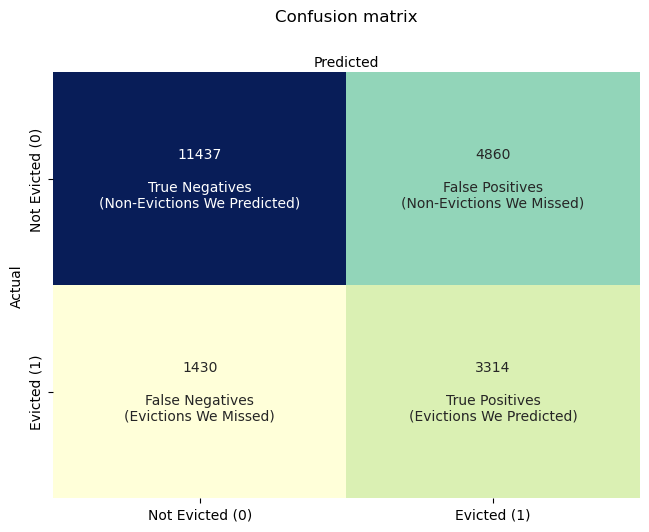

In [23]:
demo13.confusion_matrix(y_test, y_pred)

# Assessing Model "Fit"

Always going to be a balance more and less sensitivity to the outcome you want to predict.

Do you want more or fewer false alarms? How much do you want to "cry wolf"?

### Accuracy
Proportion of correct classifications

$$
Accuracy = \frac{Correct Classifications}{Total Classifications} = \frac{True Positives + True Negatives}{True Positives + True Negatives + False Positives + False Negatives}
$$

### Precision or Specificity
Proportion of predicted outcomes that were correct

(False Positive Rate = 1 - Specificity)

$$
Precision = \frac{True}{Predicted} = \frac{True Positives}{True Positives + False Positives}
$$

### Recall, Sensitivity, True Positive Rate
Proportion of actual outcomes that were correctly predicted

$$
Recall = \frac{True}{Actual} = \frac{True Positives}{True Positives + False Negatives}
$$

In [24]:
demo13.precision_recall_table(y_test, y_pred)

,precision,recall,f1-score,support
not evicted,0.888863,0.701786,0.784323,16297.00000
evicted,0.405432,0.698567,0.513083,4744.00000
accuracy,0.701060,0.701060,0.701060,0.70106
macro avg,0.647147,0.700176,0.648703,21041.00000
weighted avg,0.779866,0.701060,0.723168,21041.00000


### Receiver Operating Characteristic (ROC) Curve

Shows the performance of the model at all possible classification thresholds.

The closer the curve is to a right angle, the better the model.

Area Under the Curve (AUC) summarizes performance; better models approach 1.0.

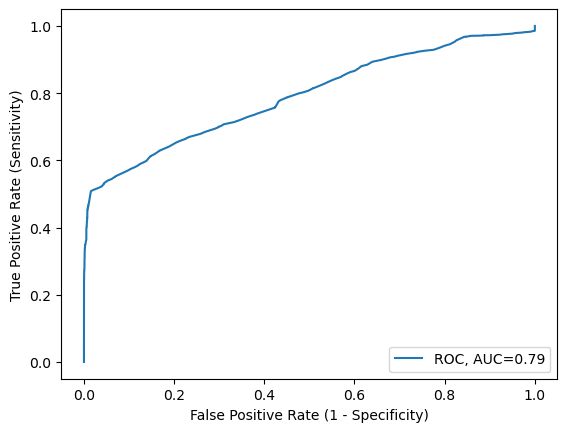

In [25]:
demo13.roc_plot(logreg, y_test, X_test)

# Random Forest

A collection of (many, many) decision trees

<img alt="Random forest decision tree example" src='https://miro.medium.com/v2/resize:fit:1184/format:webp/1*i0o8mjFfCn-uD79-F1Cqkw.png'>

[Source: https://williamkoehrsen.medium.com/random-forest-simple-explanation-377895a60d2d](https://williamkoehrsen.medium.com/random-forest-simple-explanation-377895a60d2d)

## Train

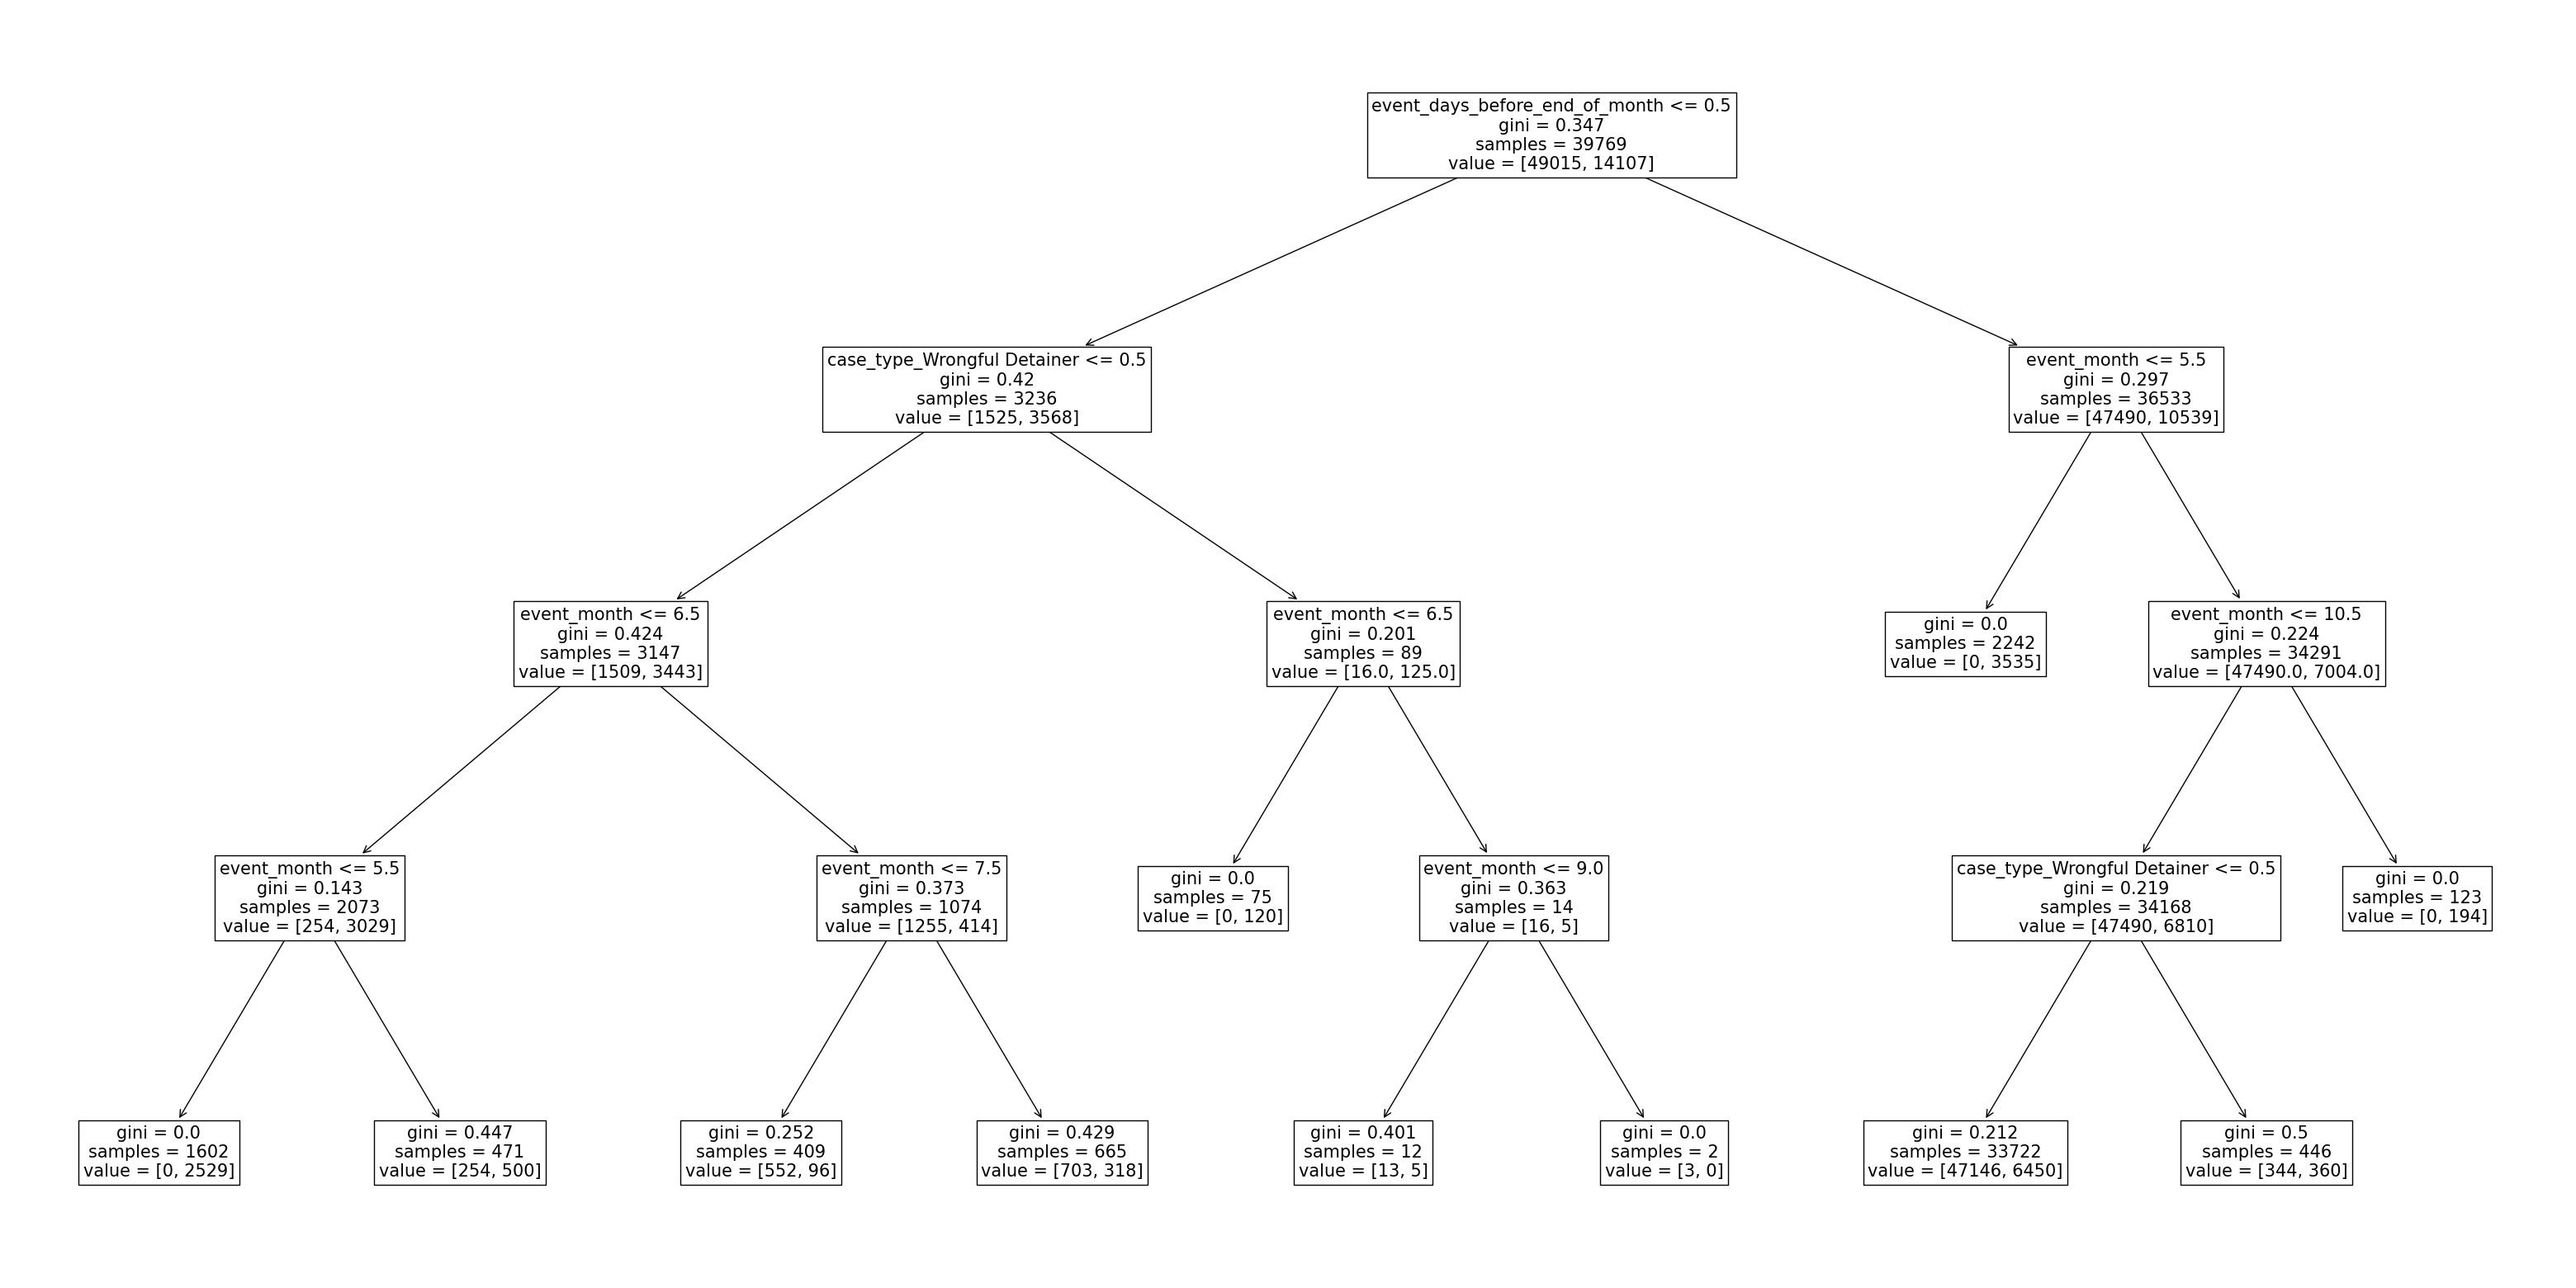

In [26]:
# Initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1, n_jobs=-1, max_depth=4) 

# Fit the model based on training data
rf.fit(X_train, y_train)

# Visualize the first estimator/tree
e = rf.estimators_[0]

fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)

In [27]:
## Now let's allow the depth of decision trees to be unlimited
## (Nodes are expanded until each leaf contains one observation)

# Initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 100, random_state = 1, max_depth=None)

# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

## Test

In [28]:
y_pred = rf.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

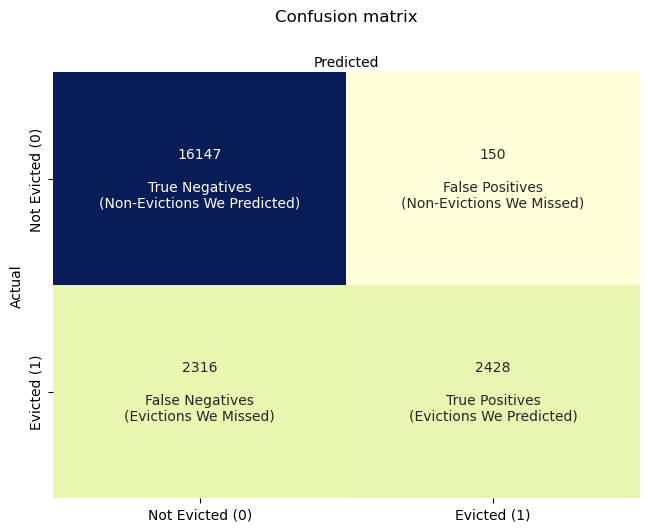

In [29]:
demo13.confusion_matrix(y_test, y_pred)

In [30]:
demo13.precision_recall_table(y_test, y_pred)

,precision,recall,f1-score,support
not evicted,0.874560,0.990796,0.929056,16297.0000
evicted,0.941815,0.511804,0.663207,4744.0000
accuracy,0.882800,0.882800,0.882800,0.8828
macro avg,0.908188,0.751300,0.796132,21041.0000
weighted avg,0.889724,0.882800,0.869117,21041.0000


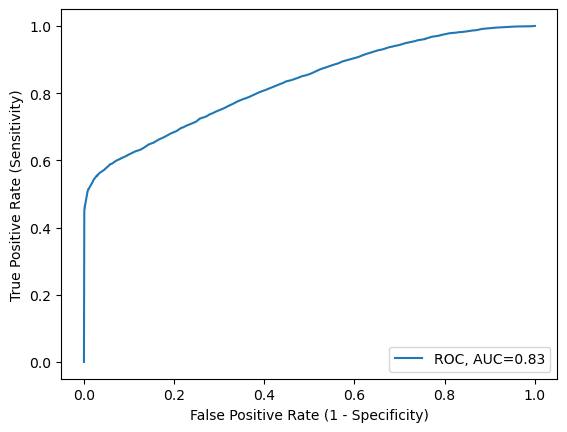

In [36]:
demo13.roc_plot(rf, y_test, X_test)